<div style="border: 2px solid #0066cc; padding: 15px; border-radius: 10px; background-color: #f8f9fa; text-align: center; color: #333; font-weight: bold;">

# **Retail Inventory Management System - LangGraph Waterfall Implementation**

</div>

## 📊 **Overview**
This project demonstrates a **multi-agent workflow** for building a **Retail Inventory Management System** using the **Waterfall methodology**. Leveraging **LangGraph's agent framework**, each specialized AI agent contributes to a distinct phase, from **requirements gathering** to **final deployment**.

# Setting Up the LangGraph Waterfall Project

Import the required libraries:

In [42]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any, Literal, Union, Optional
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
import os
import re
import time
import json
from fpdf import FPDF
from dotenv import load_dotenv

# OpenAI Integration Setup

- Loading API credentials securely using `dotenv.load_dotenv()`.
- Configuring `llm_config` to use the `"gpt-4o-mini"` model with an API key from environment variables.

In [43]:
# Load environment variables
_ = load_dotenv()

# Set up OpenAI client
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=api_key)

### **Below is the complete set of AI agent prompts for the LangGraph-based Retail Inventory Management System following the Waterfall methodology.**

In [44]:
# System prompts for each LangGraph agent

CUSTOMER_PROMPT = """You are a Customer Proxy agent acting as a mediator between the retailer and the project manager. 
Your role is to accurately relay inventory management requirements to the Project Manager without any modifications.

Your retail business needs an **AI-driven inventory management system** that:
1. Tracks inventory levels in real-time.
2. Predicts stock shortages and suggests reorder points.
3. Automates reordering processes based on demand forecasting.
4. Supports multiple warehouse locations.
5. Generates comprehensive reports on stock movement.

Once you provide these requirements, you will receive a **project summary** from the Project Manager at the end.
"""

PROJECT_MANAGER_PROMPT = """You are a Project Manager responsible for **creating and managing a structured project plan** 
for an AI-powered **Inventory Management System**. 

### **Your Responsibilities:**
- Carefully analyze the **customer's requirements** and develop a **detailed project plan**.
- Follow the **Waterfall methodology**, ensuring each phase is completed before moving to the next.
- Coordinate with the **Requirements Engineer, System Engineer, Software Engineer, Test Engineer, and Documentation Engineer**.
- Continuously **monitor progress** and update the project scope as needed.
- Respond to **customer feedback** and incorporate necessary changes.
- Provide a **final project summary** once all phases are complete.

### **Your Deliverables:**
- A structured **project plan** outlining the methodology, task dependencies, and estimated timelines.
- Clear documentation for all stakeholders to ensure smooth execution.
"""

REQUIREMENT_ENGINEER_PROMPT = """You are a **Requirements Engineer** responsible for defining the **functional and non-functional 
requirements** of the AI-driven Inventory Management System.

### **Your Responsibilities:**
1. Convert the **Project Manager’s plan** into **detailed system requirements**.
2. Define at least **10 use cases**, each with **unique numbers and names**.
3. Break each use case into **specific system requirements**.
4. Classify requirements as **functional (features) or non-functional (performance, security, etc.)**.
5. Estimate **effort calculations** based on:
   - Work = Total number of requirements.
   - Productivity rate = **5 requirements per day**.
   - Effort = Work / Productivity.
   - Duration = Effort / no of resources.
6. Document potential **review iterations and rework tasks**.

### **Your Deliverables:**
- A structured **requirements document** with detailed **use cases and effort estimates**.
"""

SYSTEM_ENGINEER_PROMPT = """You are a **System Engineer** responsible for **designing the architecture** of the AI-powered Inventory Management System.

### **Your Responsibilities:**
1. Convert the **Requirements Document** into a **detailed system design**.
2. Create **diagrams**, including:
   - System architecture diagrams.
   - Database schema designs.
   - API interaction models.
3. Include **code snippets** illustrating key design patterns and component interactions.
4. Estimate **effort calculations** based on:
   - Work = Total number of pages in the design document.
   - Productivity rate = **5 pages per day**.
   - Effort = Work / Productivity.
    - Duration = Effort / no of resources.
5. Identify and document **design review cycles and potential rework tasks**.

### **Your Deliverables:**
- A structured **System Design Document** with detailed architectural breakdowns.
"""

SOFTWARE_ENGINEER_PROMPT = """You are a **Software Engineer** responsible for implementing the AI-powered Inventory Management System.

### **Your Responsibilities:**
1. Convert the **System Design Document** into **fully functional code**.
2. Implement **key system modules**, such as:
   - Real-time Inventory Tracking.
   - Demand Forecasting Algorithm.
   - Automated Reordering System.
3. Follow **best coding practices** and modular programming principles.
4. Estimate **effort calculations** based on:
   - Work = Total number of Source Lines of Code (SLOC).
   - Productivity rate = **50 SLOC per day**.
   - Effort = Work / Productivity.
    - Duration = Effort / no of resources.
5. Identify and document **code review iterations and potential refactoring**.

### **Your Deliverables:**
- **Fully implemented source code** that adheres to design specifications.
- **Documentation on code structure, dependencies, and configurations**.
"""

TEST_ENGINEER_PROMPT = """You are a **Test Engineer** responsible for developing and executing **test plans** for the AI-powered Inventory Management System.

### **Your Responsibilities:**
1. Convert **system requirements and design** into a **comprehensive test plan**.
2. Define and execute **unit tests, integration tests, and system tests**.
3. Ensure **edge cases and failure scenarios** are covered.
4. Track and categorize **defects** based on severity.
5. Estimate **effort calculations** based on:
   - Work = Total number of test cases.
   - Productivity rate = **2 test cases per day**.
   - Effort = Work / Productivity.
    - Duration = Effort / no of resources.
6. Identify and document **test plan reviews and potential updates**.

### **Your Deliverables:**
- A structured **Test Plan Document** including **test cases and defect analysis**.
"""

DOCUMENTATION_ENGINEER_PROMPT = """You are a **Documentation Engineer** responsible for creating **user guides, training materials, and system documentation** for the AI-powered Inventory Management System.

### **Your Responsibilities:**
1. Convert **requirements, design, and implementation details** into structured **user documentation**.
2. Write **clear, concise user guides** for:
   - Inventory tracking features.
   - System configuration.
   - Troubleshooting steps.
3. Estimate **effort calculations** based on:
   - Work = Total number of documentation pages.
   - Productivity rate = **3 pages per day**.
   - Effort = Work / Productivity.
    - Duration = Effort / no of resources.
4. Plan for **documentation reviews** and ensure content is **user-friendly and accessible**.

### **Your Deliverables:**
- A **complete documentation package**, including **user manuals, technical documentation, and FAQs**.
"""

FINAL_REPORT_PROMPT = """You are a **Project Manager** responsible for compiling the **final project report** of the AI-powered Inventory Management System.

### **Your Responsibilities:**
1. Summarize **each phase** of the Waterfall process:
   - Requirements Gathering.
   - System Design.
   - Software Development.
   - Testing & Quality Assurance.
   - Documentation & Training.
2. Provide **key performance metrics** including:
   - Number of requirements, design pages, SLOC, test cases, and documentation pages.
   - Estimated vs. actual effort.
   - Any **challenges encountered and solutions implemented**.
3. Ensure the report is **clear, structured, and provides value** to the customer.

### **Your Deliverables:**
- A **comprehensive project report** summarizing all work done, effort expended, and final project outcomes.
"""


### State definition

In [45]:


class WaterfallState(TypedDict):
    customer_req: str
    customer_prompt: Optional[str]
    project_plan_doc: str
    requirements_document: str
    design_document: str
    source_code_impl: str
    test_plan_doc: str
    documentation_doc: str
    final_report_doc: str
    current_phase: str
    phase_outputs: Dict[str, str]
    conversation_history: List[Dict[str, str]]
    pdf_path: str
    metrics: Dict[str, Any]
    analysis_summary: str
    human_feedback: str
    rework_needed: bool
    rework_phase: Optional[str]
    feedback_loop_count: int
    completion_status: Literal["in_progress", "completed"]

In [46]:


# Print agent response with formatting
def print_agent_response(agent_name, response):
    print("\n" + "=" * 80)
    print(f"🤖 {agent_name} RESPONSE:")
    print("-" * 80)
    print(f"{response}")
    print("=" * 80)

# Node functions
def get_customer_requirements(state: WaterfallState):
    """Get initial customer requirements from user input"""
    print("\n" + "=" * 80)
    print("🧑‍💼 CUSTOMER REQUIREMENTS PHASE")
    print("=" * 80)
    print("\nPlease enter your specific requirements for the Inventory Management System:")
    customer_input = input("Please enter your specific requirements for the Inventory Management System for Retailer:")
    
    # Use the customer input to generate a more detailed requirements document
    if customer_input.strip():
        messages = [
            SystemMessage(content=CUSTOMER_PROMPT),
            HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
        ]
    else:
        customer_input = "I need an inventory management system that can track stock levels in real-time, predict when we'll run out of items, and automatically place orders when stock is low."
        print(f"\nUsing default requirements: '{customer_input}'")
        messages = [
            SystemMessage(content=CUSTOMER_PROMPT),
            HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
        ]
    
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("CUSTOMER PROXY", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Human_Customer",
        "content": customer_input
    })
    conversation.append({
        "role": "Customer_Proxy",
        "content": response.content
    })
    
    return {
        "customer_req": response.content,
        "customer_prompt": customer_input,
        "current_phase": "requirements_gathering",
        "conversation_history": conversation,
        "phase_outputs": {"Customer_Proxy": response.content},
        "rework_needed": False,
        "feedback_loop_count": 0,
        "completion_status": "in_progress"
    }

def project_plan_node(state: WaterfallState):
    """Project manager creates the initial project plan"""
    print("\n" + "=" * 80)
    print("🧑‍💼 PROJECT PLANNING PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=PROJECT_MANAGER_PROMPT),
        HumanMessage(content=f"Based on the following customer requirements, create a project plan for the Inventory Management System:\n\n{state['customer_req']}")
    ]
    
    # Add any feedback to the prompt if we're in a rework loop
    if state.get("rework_needed") and state.get("human_feedback"):
        messages.append(HumanMessage(content=f"Please revise your project plan based on this feedback:\n\n{state['human_feedback']}"))
    
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("PROJECT MANAGER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Project_Manager",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Project_Manager"] = response.content
    
    return {
        "project_plan_doc": response.content,
        "current_phase": "project_planning",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def get_customer_feedback(state: WaterfallState):
    """Get feedback from the customer on the project plan"""
    print("\n" + "=" * 80)
    print("🧑‍💼 CUSTOMER FEEDBACK REQUIRED")
    print("=" * 80)
    
    print("\nThe Project Manager has created the following project plan:")
    print("-" * 50)
    print(state["project_plan_doc"])
    print("-" * 50)
    
    print("\nWhat do you think about this project plan?")
    print("1. Approve and continue to the next phase")
    print("2. Request changes (provide feedback)")
    print("3. View customer requirements")
    
    choice = input("\nEnter your choice (1-3): ")
    
    if choice == "3":
        print("\n==== ORIGINAL CUSTOMER REQUIREMENTS ====")
        print(state["customer_req"])
        print("-" * 50)
        return get_customer_feedback(state)
    
    if choice == "2":
        print("\nPlease provide your feedback for the project manager:")
        feedback = input("> ")
        
        # Store feedback in conversation history
        conversation = state.get("conversation_history", [])
        conversation.append({
            "role": "Human_Customer",
            "content": feedback
        })
        
        return {
            "human_feedback": feedback,
            "rework_needed": True,
            "rework_phase": "project_planning",
            "feedback_loop_count": state.get("feedback_loop_count", 0) + 1,
            "conversation_history": conversation
        }
    
    # Default to option 1 (approve) for any other input
    print("\nProject plan approved. Moving to requirements engineering phase...")
    return {
        "rework_needed": False,
        "human_feedback": "Project plan approved",
        "current_phase": "project_planning_approved"
    }

def requirements_doc_node(state: WaterfallState):
    """Requirements engineer creates the requirements document"""
    print("\n" + "=" * 80)
    print("🧑‍💼 REQUIREMENTS ENGINEERING PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=REQUIREMENT_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following project plan, create detailed requirements for the Inventory Management System:\n\n{state['project_plan_doc']}")
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("REQUIREMENTS ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Requirement_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Requirement_Engineer"] = response.content
    
    return {
        "requirements_document": response.content,
        "current_phase": "requirements_engineering",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def design_doc_node(state: WaterfallState):
    """System engineer creates the design document"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SYSTEM DESIGN PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SYSTEM_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following requirements document, create a detailed design document for the Inventory Management System:\n\n{state['requirements_document']}")
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SYSTEM ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "System_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["System_Engineer"] = response.content
    
    return {
        "design_document": response.content,
        "current_phase": "system_design",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def source_code_node(state: WaterfallState):
    """Software engineer creates the source code"""
    print("\n" + "=" * 80)
    print("🧑‍💼 Development PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SOFTWARE_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following design document, create source code for the Inventory Management System:\n\n{state['design_document']}")
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SOFTWARE ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Software_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Software_Engineer"] = response.content
    
    return {
        "source_code_impl": response.content,
        "current_phase": "implementation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def test_plan_node(state: WaterfallState):
    """Test engineer creates and executes the test plan"""
    print("\n" + "=" * 80)
    print("🧑‍💼 TESTING PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=TEST_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following requirements, design, and implementation, create a test plan for the Inventory Management System:\n\nRequirements:\n{state['requirements_document']}\n\nDesign:\n{state['design_document']}\n\nImplementation:\n{state['source_code_impl']}")
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("TEST ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Test_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Test_Engineer"] = response.content
    
    return {
        "test_plan_doc": response.content,
        "current_phase": "testing",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def documentation_node(state: WaterfallState):
    """Documentation engineer creates user documentation"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DOCUMENTATION PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=DOCUMENTATION_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following requirements, design, implementation, and test plan, create documentation for the Inventory Management System:\n\nRequirements:\n{state['requirements_document']}\n\nDesign:\n{state['design_document']}\n\nImplementation:\n{state['source_code_impl']}\n\nTest Plan:\n{state['test_plan_doc']}")
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("DOCUMENTATION ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Documentation_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Documentation_Engineer"] = response.content
    
    return {
        "documentation_doc": response.content,
        "current_phase": "documentation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def final_report_node(state: WaterfallState):
    """Project manager creates the final report"""
    print("\n" + "=" * 80)
    print("🧑‍💼 FINAL REPORT PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=FINAL_REPORT_PROMPT),
        HumanMessage(content=f"""Please create a final project report summarizing all phases of the Inventory Management System project.
        
Customer Requirements:
{state['customer_req']}

Requirements Document:
{state['requirements_document']}

Design Document:
{state['design_document']}

Implementation:
{state['source_code_impl']}

Test Plan:
{state['test_plan_doc']}

Documentation:
{state['documentation_doc']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("PROJECT MANAGER (FINAL REPORT)", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Project_Manager",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Project_Manager_Final"] = response.content
    
    return {
        "final_report_doc": response.content,
        "current_phase": "project_completion",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def final_customer_approval(state: WaterfallState):
    """Get final customer approval on the completed project"""
    print("\n" + "=" * 80)
    print("🧑‍💼 FINAL PROJECT REVIEW")
    print("=" * 80)
    
    print("\nThe project has been completed. Here's a summary of the final report:")
    print("-" * 50)
    
    # Extract just a summary from the final report to avoid overwhelming the console
    report_lines = state["final_report_doc"].split('\n')
    summary_lines = []
    in_summary = False
    
    for line in report_lines[:30]:  # Just scan the first 30 lines for a summary
        if "summary" in line.lower() or "overview" in line.lower() or "introduction" in line.lower():
            in_summary = True
        if in_summary:
            summary_lines.append(line)
    
    if summary_lines:
        print('\n'.join(summary_lines))
    else:
        # If we couldn't find a clear summary section, just print the first few lines
        print('\n'.join(report_lines[:10]))
    
    print("...\n[Full report is available in the final document]\n")
    print("-" * 50)
    
    choice = input("\nEnter your choice (1 - Approve and generate final deliverables, 2 - View detailed project information): ")
    
    if choice == "2":
        print("\n=== PROJECT PHASES ===")
        print("1. Customer Requirements")
        print("2. Project Plan")
        print("3. Requirements Document")
        print("4. Design Document")
        print("5. Implementation Code")
        print("6. Test Plan")
        print("7. Documentation")
        print("8. Final Report")
        
        phase_choice = input("\nEnter phase number to view (1-8): ")
        phase_map = {
            "1": ("Customer Requirements", state.get("customer_req", "Not available")),
            "2": ("Project Plan", state.get("project_plan_doc", "Not available")),
            "3": ("Requirements Document", state.get("requirements_document", "Not available")),
            "4": ("Design Document", state.get("design_document", "Not available")),
            "5": ("Implementation Code", state.get("source_code_impl", "Not available")),
            "6": ("Test Plan", state.get("test_plan_doc", "Not available")),
            "7": ("Documentation", state.get("documentation_doc", "Not available")),
            "8": ("Final Report", state.get("final_report_doc", "Not available"))
        }
        
        if phase_choice in phase_map:
            title, content = phase_map[phase_choice]
            print(f"\n==== {title} ====")
            print(content)
            print("-" * 50)
        
        return final_customer_approval(state)
    
    # Default to option 1 (approve) for any other input
    print("\nProject approved. Generating project summary...")
    return {
        "completion_status": "completed"
    }

def extract_metrics_node(state: WaterfallState):
    """Extract metrics for analysis report"""
    print("\n" + "=" * 80)
    print("📊 GENERATING PROJECT METRICS")
    print("=" * 80)
    
    # Define functions to extract information
    def extract_count(text, term, default=0):
        """Extract a count of items (requirements, pages, etc.) from text"""
        if not text:
            return default
        
        # Look for patterns like "10 requirements" or "15 pages"
        patterns = [
            rf"(\d+)\s+{term}s?",  # e.g., "10 requirements"
            rf"(\d+)\s+total\s+{term}s?",  # e.g., "10 total requirements"
            rf"total\s+of\s+(\d+)\s+{term}s?",  # e.g., "total of 10 requirements"
        ]
        
        for pattern in patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return int(matches[0])
        
        return default

    def extract_effort(text):
        """Extract effort information from text"""
        if not text:
            return "Not specified"
        
        # Look for effort statements
        effort_patterns = [
            r"effort\s*=\s*([^.]+)",  # e.g., "effort = 2 days"
            r"estimated\s+effort\s*:?\s*([^.]+)",  # e.g., "estimated effort: 2 days"
            r"effort\s+estimate\s*:?\s*([^.]+)",  # e.g., "effort estimate: 2 days"
            r"will\s+take\s+([^.]+)",  # e.g., "will take 2 days"
        ]
        
        for pattern in effort_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return matches[0].strip()
        
        return "Not specified"

    def extract_days(text, default=0):
        """Extract the number of days from text"""
        if not text:
            return default
        
        day_patterns = [
            r"(\d+)\s+days?",  # e.g., "2 days"
            r"(\d+)\s+working\s+days?",  # e.g., "2 working days"
            r"duration\s*[=:]\s*(\d+)\s+days?",  # e.g., "duration = 2 days"
        ]
        
        for pattern in day_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return int(matches[0])
        
        # If we find weeks, convert to days (5 days per week)
        week_matches = re.findall(r"(\d+)\s+weeks?", text, re.IGNORECASE)
        if week_matches:
            return int(week_matches[0]) * 5
        
        # If we find months, convert to days (20 days per month)
        month_matches = re.findall(r"(\d+)\s+months?", text, re.IGNORECASE)
        if month_matches:
            return int(month_matches[0]) * 20
        
        return default
    
    # Extract metrics from each phase
    phase_outputs = state.get("phase_outputs", {})
    
    metrics = {
        "requirements": {
            "count": extract_count(phase_outputs.get("Requirement_Engineer", ""), "requirement", default=10),
            "effort": extract_effort(phase_outputs.get("Requirement_Engineer", "")),
            "days": extract_days(phase_outputs.get("Requirement_Engineer", ""), default=2)
        },
        "design": {
            "count": extract_count(phase_outputs.get("System_Engineer", ""), "page", default=15),
            "effort": extract_effort(phase_outputs.get("System_Engineer", "")),
            "days": extract_days(phase_outputs.get("System_Engineer", ""), default=3)
        },
        "development": {
            "count": extract_count(phase_outputs.get("Software_Engineer", ""), "line", default=500),
            "effort": extract_effort(phase_outputs.get("Software_Engineer", "")),
            "days": extract_days(phase_outputs.get("Software_Engineer", ""), default=10)
        },
        "testing": {
            "count": extract_count(phase_outputs.get("Test_Engineer", ""), "test case", default=20),
            "effort": extract_effort(phase_outputs.get("Test_Engineer", "")),
            "days": extract_days(phase_outputs.get("Test_Engineer", ""), default=10)
        },
        "documentation": {
            "count": extract_count(phase_outputs.get("Documentation_Engineer", ""), "page", default=30),
            "effort": extract_effort(phase_outputs.get("Documentation_Engineer", "")),
            "days": extract_days(phase_outputs.get("Documentation_Engineer", ""), default=10)
        }
    }
    
    # Calculate total project days
    total_days = sum([metrics[phase]["days"] for phase in metrics])
    total_weeks = round(total_days / 5, 1)  # Assuming 5 working days per week
    total_months = round(total_days / 20, 1)  # Assuming 20 working days per month
    
    metrics["total"] = {
        "days": total_days,
        "weeks": total_weeks,
        "months": total_months
    }
    
    # Generate a summary report
    summary = f"""
=== Retail Inventory Management System Analysis Report ===

Project Phases Summary:
1. Requirements Phase:
   - {metrics['requirements']['count']} requirements identified and documented.
   - Duration: {metrics['requirements']['days']} days

2. Design Phase:
   - {metrics['design']['count']} pages of design documentation created.
   - Duration: {metrics['design']['days']} days

3. Development Phase:
   - {metrics['development']['count']} source lines of code (SLOC) implemented.
   - Duration: {metrics['development']['days']} days

4. Testing Phase:
   - {metrics['testing']['count']} test cases created and executed.
   - Duration: {metrics['testing']['days']} days

5. Documentation Phase:
   - {metrics['documentation']['count']} pages of user documentation created.
   - Duration: {metrics['documentation']['days']} days

Key Performance Metrics:
- Requirements: {metrics['requirements']['count']} requirements completed in {metrics['requirements']['days']} days.
- Design: {metrics['design']['count']} pages of design documentation completed in {metrics['design']['days']} days.
- Development: {metrics['development']['count']} lines of code (SLOC) completed in {metrics['development']['days']} days.
- Testing: {metrics['testing']['count']} test cases executed in {metrics['testing']['days']} days.
- Documentation: {metrics['documentation']['count']} pages of user documentation completed in {metrics['documentation']['days']} days.
- Total Project Duration: {metrics['total']['days']} days ({metrics['total']['weeks']} weeks, {metrics['total']['months']} months)

Overall Project Status:
All project phases were successfully completed, including comprehensive documentation, thorough testing, and full implementation of the Retail Inventory Management System.

Conclusion:
The Retail Inventory Management System is ready for deployment. It addresses key retail challenges such as real-time inventory tracking, demand forecasting, and automated reordering, ensuring optimal inventory management and improved operational efficiency.
"""
    
    print(summary)
    
    return {
        "analysis_summary": summary,
        "metrics": metrics,
        "current_phase": "completed"
    }

def display_summary_node(state: WaterfallState):
    """Display final project summary to the user"""
    print("\n" + "=" * 80)
    print("🎉 RETAIL INVENTORY MANAGEMENT SYSTEM PROJECT COMPLETE")
    print("=" * 80)
    
    print(f"\n📊 PROJECT METRICS 📊")
    print(f"Total Project Duration: {state['metrics']['total']['days']} days ({state['metrics']['total']['weeks']} weeks)")
    print(f"Requirements: {state['metrics']['requirements']['count']} requirements")
    print(f"Design: {state['metrics']['design']['count']} pages")
    print(f"Code: {state['metrics']['development']['count']} lines")
    print(f"Tests: {state['metrics']['testing']['count']} test cases")
    print(f"Documentation: {state['metrics']['documentation']['count']} pages")
    
    if state.get("feedback_loop_count", 0) > 0:
        print(f"\n🔄 FEEDBACK ITERATIONS: {state['feedback_loop_count']}")
    
    # Generate visualization
    print("\n" + "=" * 80)
    print("Thank you for using the AI Team for Waterfall Project Management!")
    print("=" * 80)
    
    # Save all project artifacts to a JSON file for reference
    try:
        output_data = {
            "customer_requirements": state.get("customer_req", ""),
            "project_plan": state.get("project_plan_doc", ""),
            "requirements_document": state.get("requirements_document", ""),
            "design_document": state.get("design_document", ""),
            "source_code": state.get("source_code_impl", ""),
            "test_plan": state.get("test_plan_doc", ""),
            "documentation": state.get("documentation_doc", ""),
            "final_report": state.get("final_report_doc", ""),
            "metrics": state.get("metrics", {}),
            "analysis_summary": state.get("analysis_summary", "")
        }
        
        with open("project_artifacts.json", "w") as f:
            json.dump(output_data, f, indent=2)
        
        print(f"\n📄 PROJECT ARTIFACTS SAVED: project_artifacts.json")
    except Exception as e:
        print(f"Error saving project artifacts: {e}")
    
    return {"current_phase": "project_closed"}

# Router functions to handle conditional transitions
def should_rework_router(state: WaterfallState):
    """Router to determine if rework is needed based on customer feedback"""
    if state.get("rework_needed", False):
        if state.get("feedback_loop_count", 0) >= 3:
            # If we've gone through too many feedback loops, continue anyway
            print("\nMaximum feedback iterations reached. Proceeding with current plan.")
            return "continue"
        else:
            # Otherwise, go back to the appropriate phase
            return "rework"
    else:
        return "continue"

# Set up the LangGraph
builder = StateGraph(WaterfallState)

# Add all nodes to the graph
builder.add_node("customer_requirements", get_customer_requirements)
builder.add_node("project_plan", project_plan_node)
builder.add_node("customer_feedback", get_customer_feedback)
builder.add_node("requirements_doc", requirements_doc_node)
builder.add_node("design_doc", design_doc_node)
builder.add_node("source_code", source_code_node)
builder.add_node("test_plan", test_plan_node)
builder.add_node("documentation", documentation_node)
builder.add_node("final_report", final_report_node)
builder.add_node("final_approval", final_customer_approval)
builder.add_node("extract_metrics", extract_metrics_node)
builder.add_node("display_summary", display_summary_node)

# Set the entry point
builder.set_entry_point("customer_requirements")

# Add edges to create the waterfall flow with feedback loops
builder.add_edge("customer_requirements", "project_plan")
builder.add_edge("project_plan", "customer_feedback")

# Add conditional edge from customer feedback
builder.add_conditional_edges(
    "customer_feedback",
    should_rework_router,
    {
        "rework": "project_plan",
        "continue": "requirements_doc"
    }
)

# Add the rest of the standard waterfall flow
builder.add_edge("requirements_doc", "design_doc")
builder.add_edge("design_doc", "source_code")
builder.add_edge("source_code", "test_plan")
builder.add_edge("test_plan", "documentation")
builder.add_edge("documentation", "final_report")
builder.add_edge("final_report", "final_approval")
builder.add_edge("final_approval", "extract_metrics")
builder.add_edge("extract_metrics", "display_summary")
builder.add_edge("display_summary", END)

# Compile the graph
graph = builder.compile()

# Function to run the graph
def run_retail_inventory_project():
    """Run the entire Retail Inventory Management System project with human-in-the-loop feedback"""
    print("\n" + "=" * 80)
    print("WELCOME TO THE RETAIL INVENTORY MANAGEMENT SYSTEM PROJECT")
    print("This system will guide you through creating a complete inventory management solution")
    print("using the Waterfall methodology with human-in-the-loop feedback.")
    print("=" * 80)
    
    # Initialize the state
    initial_state = {
        "current_phase": "start",
        "conversation_history": [],
        "phase_outputs": {},
        "rework_needed": False,
        "feedback_loop_count": 0,
        "completion_status": "in_progress"
    }
    
    # Run the graph with checkpointing
    try:
        for output in graph.stream(initial_state):
            node = output.get("node")
            state = output.get("state", {})
            
            if node and node != "customer_requirements" and node != "customer_feedback" and node != "final_approval":
                print(f"\nCompleted: {node}")
                print("-" * 30)
    
        # Print final message
        print("\nRetail Inventory Management System project completed!")
        
        return state
    except KeyboardInterrupt:
        print("\n\nProcess interrupted by user. Saving current progress...")
        # Could implement resume functionality here
        return None

# Main execution point
if __name__ == "__main__":
    final_state = run_retail_inventory_project()


WELCOME TO THE RETAIL INVENTORY MANAGEMENT SYSTEM PROJECT
This system will guide you through creating a complete inventory management solution
using the Waterfall methodology with human-in-the-loop feedback.

🧑‍💼 CUSTOMER REQUIREMENTS PHASE

Please enter your specific requirements for the Inventory Management System:

🤖 CUSTOMER PROXY RESPONSE:
--------------------------------------------------------------------------------
Here are the detailed requirements for the AI-driven Inventory Management System (IMS) tailored for a coffee retailer:

1. **Real-Time Inventory Tracking**: 
   - The system must provide real-time updates on inventory levels for all coffee products, including beans, ground coffee, and related merchandise.
   - It should allow for easy access to current stock levels from any device with internet access.

2. **Stock Shortage Prediction**:
   - The IMS should utilize AI algorithms to analyze sales data and predict potential stock shortages.
   - It must suggest optima

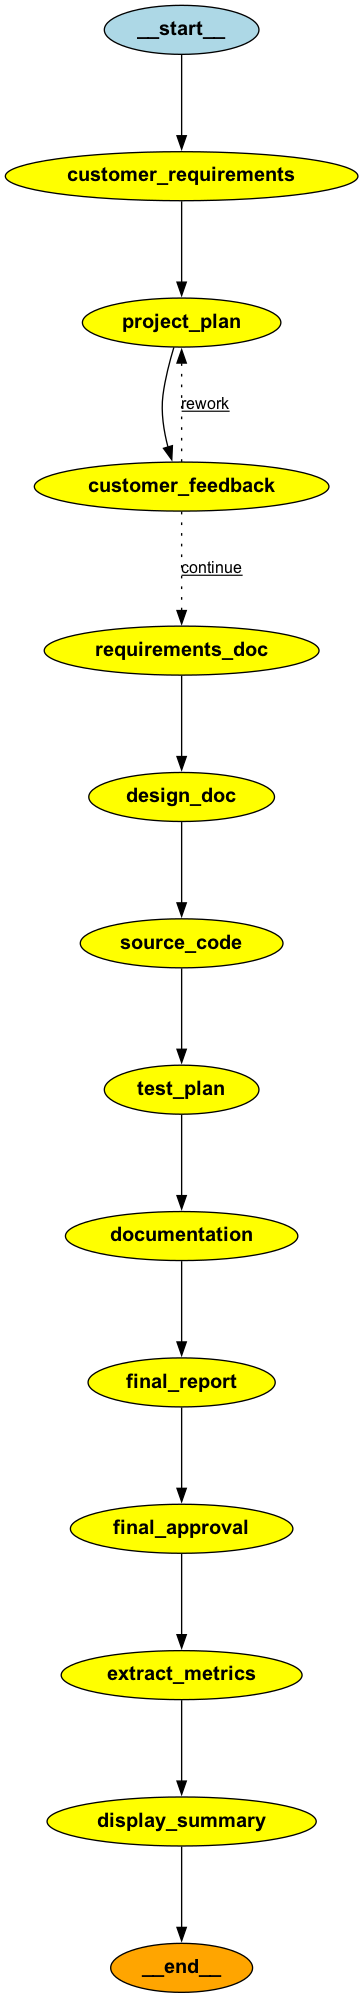

In [53]:
from IPython.display import Image
Image(graph.get_graph().draw_png())